# Discount Curves, Interpolation and Forward Rates

* Discount factors are usually presented as curves (*discount curves*) where each point represents the discount relative to a future date
  * discount curves are analogous to **yield curves**.

<center>

![alt text](https://drive.google.com/uc?id=1qdOggwArqUmlPhHZZPXigMG3MSHALqVS)

</center>

* Since discount factors are available only at discrete times we need a procedure to determine the factors at **every** time; the simplest technique is called *interpolation*.

# Interpolation

## Linear interpolation

* Imagine to have sampled few points of a function $f(x)$ which depends on $\mathbf{x}$.

* We want to estimate $f(x)$ at $x=\hat{x}$ which is not in our sample.

* **Interpolation is a method to "determine" new points within a range of a discrete set of known data points.**

#### Example
* Assume you are travelling by car at *constant speed*
  * constant speed means that travelled distance is $s = v \cdot t$;
  * if you plot the distances $s$ as a function of the time $t$ you get a line with slope $v$.

* Few samples of the distance have been recorded at different times:

<table>
<tr>
<td><b>Time (minutes)</b></td>
<td><b>Distance (km)</b></td>
</tr>
<tr>
<td align='center'>15</td>
<td align='center'>25.75</td>
</tr>
<tr>
<td align='center'>100</td>
<td align='center'>171.7</td>
</tr>
<tr>
<td align='center'>150</td>
<td align='center'>257.7</td>
</tr>
<tr>
<td align='center'>200</td>
<td align='center'>300</td>
</tr>
</table>

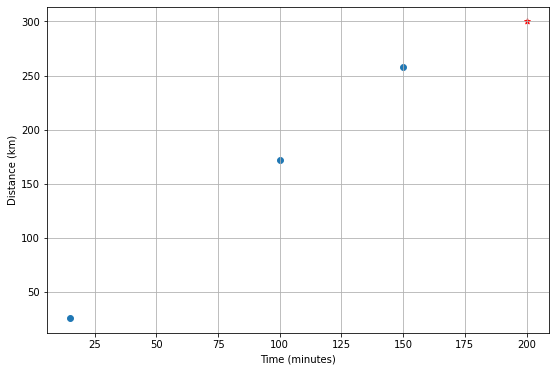

In [ ]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (9,6)

t = [15, 100, 150]
s = [25.75, 171.7, 257.7]

t_ex = [200]
s_ex = [300]

plt.scatter(t, s, marker="o", s=35)
plt.scatter(t_ex, s_ex, marker="*", s=35, color="red")
plt.xlabel("Time (minutes)")
plt.ylabel("Distance (km)")
plt.grid(True)
plt.show()

* To find the position at an intermediate time ($t_1 \leq t \leq t_2$) we can **linearly interpolate** between two sampled distances $s_1$ and $s_2$ (taken at $t_1$ and $t_2$).
  * it works pretty much like a *weighted average* of the two sampled distances (full derivation in the notes);
  * the closer point has more *influence* than the farther in the result. 

* Let's find the distance at $t = 60$ by interpolating between the two closer sampled points using the `python` function `numpy.interp`.

In [ ]:
# the numpy.interp function linearly interpolates
import numpy as np


* **Always Interpret Critically your Results**: in this case $t=60$ is almost in the middle of the interval $[t_1, t_2]$, so we expect to get a distance somehow in between $s_1$ and $s_2$

$$s(t=60) \approx 100\;\textrm{km}$$

<center>

![alt text](https://drive.google.com/uc?id=1sETZbf0Qb7shXD47e6GS4Sdsdv0uwL21)

</center> 

* If we believe the relation between our variables stays the same (e.g. keep the same constant velocity in our trip), with the same mechanism we can alsp **extrapolate** values **outside** our initial sample.

* Anyway `numpy.interp` **doesn't allow to extrapolate** returning always the closest measured value for points outside the interval.

In [ ]:
# distance travelled in 180 min trip (extrapolation)


### Log-linear interpolation

* When the function $f$ that we want to interpolate is an exponential we can fall back to the previous case by a simple variable transformation. 

$$p = \mathrm{exp}(v \cdot t)$$

$$s = \mathrm{log}(p) = \mathrm{log}(\mathrm{exp}(v \cdot t)) = v \cdot t$$

* So it is enough to use `numpy.interp` with the lists of $t$ and $\mathrm{log}(p)$ and **to exponentiate back at the end** to get the actual value of $p$.

### Limitations of Linear Interpolation

* Interpolation is just an **approximation** and works well when either the function $f$ is linear or we are trying to interpolate between two points that are close enough that $f$ is *almost* linear in that interval
  * intuitively **the "curvier" the function the worse the approximation made with simple linear interpolation**.

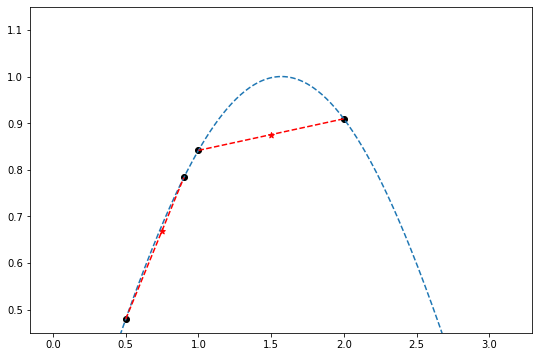

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

x = [1, 2]
y = np.sin(x)

xi = 1.5
z = np.interp(xi, x, y)
xs = np.arange(0, np.pi, 0.01)
plt.plot(xs, np.sin(xs), linestyle="--")
plt.plot([x[0],xi,x[1]], [y[0], z, y[1]], linestyle="--", color="red")
plt.scatter(x, y, marker="o", color="black")
plt.scatter(xi, z, marker="*", color="red")

xi = 0.75
z = np.interp(xi, [0.5, 0.9], np.sin([0.5, 0.9]))
plt.plot([0.5, xi, 0.9], [np.sin(0.5), z, np.sin(0.9)], linestyle="--", color="red")
plt.scatter([0.5, 0.9], np.sin([0.5, 0.9]), marker="o", color="black")
plt.scatter(xi, z, marker="*", color="red")

plt.ylim(0.45, 1.15)
plt.show()

## Back to finance

* Let's put together what we have learnt so far (OOP and interpolation) by writing a `python` class which can handle **discount curves**.

<center>

![alt text](https://drive.google.com/uc?id=1qdOggwArqUmlPhHZZPXigMG3MSHALqVS)

</center> 

* **Attributes** (characteristic data of a discount curve):
  * a list of pillar dates (corresponding to the given discount factors), $t_0,...,t_{n-1}$
  * a list of discount factors, $D(t_0),...,D(t_{n-1})$

* **Methods** ("behaviour" of a discount curve):
  * one single method returning a discount factor at a given date (if necessary it must interpolate between existing factors);
  * since $D=e^{-r(T-t)}$ the method will use a log-linear interpolation to return the value we are looking for.

$$d(t_i)=\log(D(t_i)) = \log(e^{-r(T-t_i)}) = -r(T-t_i) \;\;\textrm{where $i$ is such that}\;t_i \le t \le t_{i+1}$$


In [ ]:
# discount curve class
import numpy as np
from math import log, exp


* **Note**: `numpy.interp` only accepts lists of numbers as arguments i.e. it doesn't automatically convert dates as numbers and doesn't know how to interpolate them. So you need to set an offset $t_0$ and convert each date into the number of days since $t_0$ before passing them to `numpy.interp`.

#### Test the class

* Compute and plot the discount factor for a date at 6 months from today given this [discount curve](https://github.com/matteosan1/finance_course/raw/develop/libro/input_files/discount_factors_2022-10-05.xlsx).


In [ ]:
# load df from file 


In [ ]:
# test class in 6 months from now
import numpy as np
from datetime import date
from dateutil.relativedelta import relativedelta


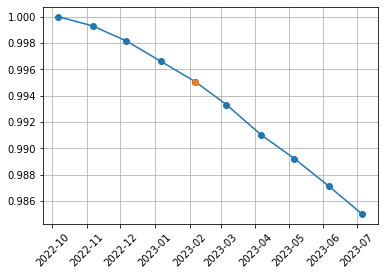

In [ ]:
from matplotlib import pyplot as plt

plt.plot(pillars[:10], dfs[:10], marker='o')
plt.plot(df_date, df0 , marker='X')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Forward Rates

* A **forward rate** is an interest rate applicable to a financial transaction that will take place in the future. 
  * It can be considered as the *market’s expectation for future prices* and can serve as an indicator of how it believes will perform.

* Contrary the **spot rate** is used by buyers and sellers looking to make an immediate purchase or sale.

## Calculating Forward Rates

* To calculate the forward rates exploit no-arbitrage argument:

$$e^{r_1 (T_1-T_0)}e^{r_{1,2}(T_2 - T_1)} = e^{r_2 (T_2-T_0)} \implies e^{r_1 T_1 + r_{1,2}(T_2 - T_1)} = e^{r_2 T_2} $$

$$r_1 T_1 + r_{1,2}(T_2 - T_1) = r_2 T_2 \implies r_{1,2} = \cfrac{r_2 T_2 - r_1 T_1 }{T_2 - T_1}$$

### Forward Rate Class

* **Attributes**: 
  * pillar dates;
  * interest rates corresponding to the pillar dates.
* **Methods**:
  * a method to interpolate rate at a given date; 
  * a method to compute the forward rate relative to a time period.

In [ ]:
# write class ForwardRate
import numpy as np


#### Test the class

* Given the following rates compute the forward rate between $t_1$ (2021-01-01) and $t_2$ (2022-01-01):

<table>
<tr><td>Date</td><td>Rate</td></tr>
<tr><td>2020-01-01</td><td>2.21%</td></tr>
<tr><td>2021-01-01</td><td>2.41%</td></tr>
<tr><td>2022-07-01</td><td>2.43%</td></tr>
</table>


In [ ]:
# test the class
from datetime import date


## `finmarkets` Module

* Since we have already written useful tools that will be frequently used in the future let's implement our personal financial module: `finmarkets.py`. 

* In order to use this module add the following cell to your notebooks:

In [ ]:
import sys
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
sys.path.append('/content/drive/MyDrive/finance_course/2022/lesson2')